<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

<a id="4"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">4- Models</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models & Evaluation
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn import metrics

## Splitting dataset in train and test

In [2]:
def adjusted_r2_score(X, r2_score):
    return 1 - ( 1- r2_score ) * ( len(X) - 1 ) / ( len(X) - X.shape[1] - 1 )

In [3]:
hourly_data = pd.read_csv('../data/interim/hourly_data.csv')

In [4]:
hourly_data.shape

(7447, 15)

In [5]:
hourly_data.columns

Index(['rental_date', 'rental_day', 'rental_year', 'rental_hour', 'holiday',
       'dayofweek', 'working_day', 'season', 'peak', 'timesofday', 'rain',
       'temp', 'rhum', 'wdsp', 'count'],
      dtype='object')

In [6]:
df = hourly_data.copy()
#df = hourlyDataWithoutOutliers.copy()
#df = transform_data.copy()
df = df.astype({'holiday': 'category', 
                'dayofweek': 'category', 
                'working_day': 'category', 
                'peak': 'category', 
                'timesofday': 'category'})
predictors = ['rain','temp','wdsp','rhum','holiday','dayofweek','working_day','peak','timesofday']

X = df[[c for c in df.columns if c in predictors]]
y = df.pop('count')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((5212, 9), (2235, 9))

## Split columns in categorical and numerical

In [7]:
num_vars = [n for n in df.select_dtypes(include=['number']).columns if n in predictors] # list comprehension to select only predictors features
cat_vars = [c for c in df.select_dtypes(include=['category']).columns if c in predictors]

In [8]:
num_vars, cat_vars

(['rain', 'temp', 'rhum', 'wdsp'],
 ['holiday', 'dayofweek', 'working_day', 'peak', 'timesofday'])

## Preprocessing Pipelines

In [9]:
# Define categorical pipeline
cat_pipe = Pipeline([
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    # ('scaler', MinMaxScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_vars),
    ('num', num_pipe, num_vars)
])

In [10]:
pipe_linear_regression = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipe_linear_regression.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe_linear_regression.predict(X_train)

# Predict test data
y_test_pred = pipe_linear_regression.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 2.961181692522742
R^2: 0.29585256740396704
Adjusted R^2: 0.2930043305979606


## Feature Importance

In [11]:
# LightGBM model
params_lightgbm = {'n_estimators': 500, 
                   'boosting_type': 'dart', 
                   'max_depth': 5, 
                   'learning_rate': 0.01, 
                   'subsample': 0.7, 
                   'importance_type': 'gain'
                   }

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(**params_lightgbm))
])
pipe_gbm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['holiday', 'dayofweek',
                                                   'working_day', 'peak',
                                                   'timesofday']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rain', 'temp', 'rhum',
                                                   'wdsp'])])),
                ('model',
                 LGBMReg

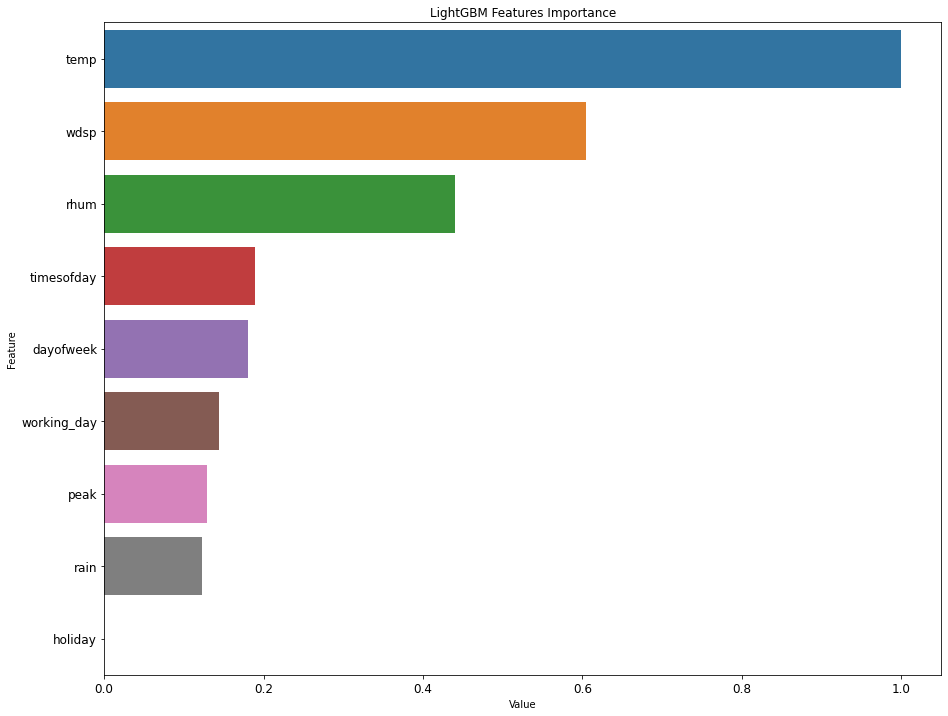

In [12]:
#Plotting features importance
feature_imp = pd.DataFrame(sorted(zip(pipe_gbm['model'].feature_importances_,X_train.columns)), columns=['Value','Feature'])
scaler_ft = MinMaxScaler()
feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1))

fig = plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

## Linear Regression

In [13]:
pipe_linear_regression = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipe_linear_regression.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe_linear_regression.predict(X_train)

# Predict test data
y_test_pred = pipe_linear_regression.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 2.961181692522742
R^2: 0.29585256740396704
Adjusted R^2: 0.2930043305979606


## Ridge Regression

[Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients with l2 regularization.

In [14]:
# Fit a pipeline with transformers and an estimator to the training data
pipe_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())
])
pipe_ridge.fit(X_train, y_train)

y_train_pred = pipe_ridge.predict(X_train)
y_test_pred = pipe_ridge.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 2.9587892010853487
R^2: 0.2969899418128631
Adjusted R^2: 0.29414630562244326


## Lasso Regression

The [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) is a linear model that estimates sparse coefficients with l1 regularization.

In [15]:
# Fit a pipeline with transformers and an estimator to the training data
pipe_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('model', linear_model.Lasso(alpha=0.1))
])
pipe_lasso.fit(X_train, y_train)
y_train_pred = pipe_lasso.predict(X_train)
y_test_pred = pipe_lasso.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.0064049623542846
R^2: 0.2741808073670551
Adjusted R^2: 0.271244909509214


## Elastic-Net

[Elastic-Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) is a linear regression model trained with both l1 and l2 -norm regularization of the coefficients.

In [16]:
# Fit a pipeline with transformers and an estimator to the training data
pipe_elastic = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])
pipe_elastic.fit(X_train, y_train)
y_train_pred = pipe_elastic.predict(X_train)
y_test_pred = pipe_elastic.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 3.2756653127822934
R^2: 0.13834674608655784
Adjusted R^2: 0.13486140708196415


## Random Forest Regressor

In [17]:
# random forest model
params_rf = {'n_estimators': 1000, 
             'max_depth': 15, 
             'random_state': 0, 
             'min_samples_split' : 5, 
             'n_jobs': -1}

# Fit a pipeline with transformers and an estimator to the training data
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**params_rf))
])
pipe_rf.fit(X_train, y_train)
y_train_pred = pipe_rf.predict(X_train)
y_test_pred = pipe_rf.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 2.9076429742081054
R^2: 0.3210846207375818
Adjusted R^2: 0.3183384461697788


## GradientBoost

In [21]:
# GBM model
params_gbm = {'n_estimators': 150, 
              'max_depth': 5, 
              'random_state': 0, 
              'min_samples_leaf' : 10, 
              'learning_rate': 0.01, 
              'subsample': 0.7, 
              'loss': 'ls'}

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(**params_gbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 2.9602473905657036
R^2: 0.2962968377025126
Adjusted R^2: 0.2934503979449048


## LightGBM

In [19]:
# LightGBM model
params_lightgbm = {'n_estimators': 1000, 
                   'max_depth': 15, 
                   'random_state': 0, 
                   'learning_rate': 0.01, 
                   'subsample': 0.7}

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(**params_lightgbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 2.9120472932052985
R^2: 0.3190263043732948
Adjusted R^2: 0.31627180403143396


## Catboost

In [20]:
# Catboost model

# Fit a pipeline with transformers and an estimator to the training data
pipe_catboost = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(verbose=1, n_estimators=100))
])
pipe_catboost.fit(X_train, y_train)
y_train_pred = pipe_catboost.predict(X_train)
y_test_pred = pipe_catboost.predict(X_test)

print('\n')
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Learning rate set to 0.30132
0:	learn: 3.2147804	total: 56.9ms	remaining: 5.63s
1:	learn: 3.0809797	total: 60ms	remaining: 2.94s
2:	learn: 3.0085848	total: 62.3ms	remaining: 2.02s
3:	learn: 2.9619424	total: 64.5ms	remaining: 1.55s
4:	learn: 2.9384535	total: 67ms	remaining: 1.27s
5:	learn: 2.9245587	total: 69.1ms	remaining: 1.08s
6:	learn: 2.8979850	total: 71.2ms	remaining: 946ms
7:	learn: 2.8824041	total: 73.5ms	remaining: 845ms
8:	learn: 2.8663948	total: 75.7ms	remaining: 766ms
9:	learn: 2.8576537	total: 78.2ms	remaining: 704ms
10:	learn: 2.8526616	total: 80.4ms	remaining: 651ms
11:	learn: 2.8475640	total: 83.4ms	remaining: 611ms
12:	learn: 2.8399863	total: 85.3ms	remaining: 571ms
13:	learn: 2.8363820	total: 87.3ms	remaining: 536ms
14:	learn: 2.8297832	total: 89.6ms	remaining: 508ms
15:	learn: 2.8241650	total: 91.9ms	remaining: 483ms
16:	learn: 2.8136565	total: 94.7ms	remaining: 462ms
17:	learn: 2.8052373	total: 97.3ms	remaining: 443ms
18:	learn: 2.7991244	total: 102ms	remaining: 435m

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini